# Demo de implementación de un algoritmo de  Hormigas (Ant System) para resolver el problema de encontrar un Máximo Óptimo definido al azar en un plano y tratando de esquivar obstáculos y máximos locales aleatorios
El código es una adaptación del ejemplo de la librería DEAP disponible en https://deap.readthedocs.io/en/master/ pero no utiliza la librería (no son necesarios los operadores ni clases) y se mejora

1) Importar librerías:

In [1]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import operator
import copy

print("\nLibrerías importadas")


Librerías importadas


2) Establecer parámetros generales de la Corrida:

In [2]:
# Espacio mínimo y máximo del espacio de búsqueda
CANT_MAXIMOS_LOCALES = 2
MIN_ESPACIO_BUSQ = 0
MAX_ESPACIO_BUSQ = 100
CANT_OBSTACULOS = 20

# Cantidad de Ciclos de la Corrida
CANT_CICLOS = 10

# Configuración de las Hormigas
CANT_HORMIGA = 20
CANT_MOV_MAX_HORMIGA = (MAX_ESPACIO_BUSQ-MIN_ESPACIO_BUSQ)*10

# Parámetros de Atracción
ATRACCION_FEROMONAS = 2.0
ATRACCION_HEURISTICA = 1.5
EVAPORACION_FEROMONAS = 0.5

# Indica si se muestra el detalle de cada ciclo
MUESTRA_DETALLE = True

print("\nParámetros de la Corrida definidos")


Parámetros de la Corrida definidos


3) Especificar los objetos Hormiga y Mapa de Búsqueda con la  Función Heurística:

In [3]:
### clase MAPA DE BÚSQUEDA

class MapaBusqueda(object):

    def __init__(self, limMin, limMax, cantMaximosLocales=0, cantObstaculos=0, valorIniFeromonas=1):
          self.limMin = limMin
          self.limMax = limMax
          self.cantMax = cantMaximosLocales
          self.cantObstaculos = cantObstaculos
          self.generarPosicionesRnd()
          self.inicializarFeromonas()

    def _reset(self):
          #self.generarPosicionesRnd()
          self.inicializarFeromonas()

    def generarPosicionesRnd(self):
      
        # Define Posiciíon inicial de las Hormigas
        self.Hormiguero = [ random.randint(self.limMin, self.limMax),  random.randint(self.limMin, self.limMax) ]      

        # Define Posiciones Random para Máximos Locales y Óptimos
        # con Heurística también al Azar (entre 1 y 100)
        # controla que el máximo local/global no se ubique en la misma posición que el Hormiguero
        self.MaximosPos = []
        self.MaximosVal = []
        self.MaxOptimoID = 0
        auxMejorVal = -99
        i = 0
        while len(self.MaximosPos)<(self.cantMax+1):

            auxPos = [ random.randint(self.limMin, self.limMax),  random.randint(self.limMin, self.limMax) ]      

            if (self.Hormiguero != auxPos):
                auxVal = random.randint(1, 100)
                self.MaximosPos.append( auxPos )
                self.MaximosVal.append( auxVal )
                
                if self.MaximosVal[self.MaxOptimoID] < auxVal:
                    self.MaxOptimoID = i
                i= i + 1

        # Agrega los obstáculos controlando que no se ubique en una posición igual al hormiguero o a un máximo
        self.ObstaculosPos = []
        while len(self.ObstaculosPos)<self.cantObstaculos:
              auxPos = [ random.randint(self.limMin, self.limMax),  random.randint(self.limMin, self.limMax) ]
                  
              i = 0
              agregaObstaculo = True
              while agregaObstaculo and i<len(self.MaximosPos):
                if (self.MaximosPos[i] == auxPos) or (self.Hormiguero == auxPos):
                      agregaObstaculo = False                      
                i= i + 1
              
              if agregaObstaculo:
                    self.ObstaculosPos.append( auxPos )      

        return True
   
    def printInformacion(self):
        # Muestra la información sobre el Mapa de Búsqueda
        print("\n++ Ubicación del Hormiguero: ", self.Hormiguero)

        print("\n## Obstáculos Generados: ", len(self.ObstaculosPos))
        for auxPos in self.ObstaculosPos:
            print("  -->", auxPos)

        print("\n** Máximos Generados: ", len(self.MaximosPos))
        for auxPos, auxVal in zip(self.MaximosPos, self.MaximosVal):
            print("  -->", auxPos, "{ ", auxVal, " } ")
        print("\n** Posición Máximo Óptimo: ", self.MaximosPos[self.MaxOptimoID], " { ",  self.MaximosVal[self.MaxOptimoID]," } **")
        print("\n")

    @property
    def posHormiguero(self):
        return self.Hormiguero         

    @property
    def posMaximos(self):
        return self.MaximosPos    

    @property
    def valMaximos(self):
        return self.MaximosVal   
        
    @property
    def posMaximoGlobal(self):
        return self.MaximosPos[self.MaxOptimoID]         
    
    @property
    def valMaximoGlobal(self):
        return self.MaximosVal[self.MaxOptimoID]  

    @property
    def posObstaculos(self):
        return self.ObstaculosPos

    def estaEnMaximo(self, posicion):
      # Indica si la posición corresponde o no a un Máximo 
      # si es verdadero devuelve el valor correspondiente, sino 0
      for i in range(len(self.MaximosPos)):
        if posicion==self.MaximosPos[i]:
          return self.MaximosVal[i]
      return 0

    def heuristica(self, posicion):
        # Define la Función Heurística para evaluar una posicion del mapa
        devuelve = 0
        disPosMenor = self.limMax
        for posMax, valMax in zip(self.MaximosPos, self.MaximosVal):

              # calcula la distancia al punto de la Particula
              sqerrors = ((x - y)**2 for x, y in zip(posicion, posMax))
              distPos =  math.fsum(sqerrors)**0.5 / 10
              
              # Si es la menor distancia calcula la Heurística
              if disPosMenor > distPos:
                  disPosMenor = distPos 
                  devuelve = ( valMax - distPos) 

          # Por las dudas controla que devuelva un valor positivo
        return max(devuelve,0)

    def inicializarFeromonas(self):
        # Inicializa el mapa de feromonas como un diccionario del tamaño prefijado con valor constante 
        self.mapaFeromonas = dict()
        self.feroDft = 1
        ## Nota: no se inicializa el mapa de feromonas con valores para no llenar la memoria
        ## lo que se hace es que si una posición es solicitada y no existe, 
        ## se asume que el valor de 'self.feroDft'
        #for x in range(self.limMin,self.limMax):
        #    for y in range(self.limMin,self.limMax):              
        #      self.mapaFeromonas[x,y] = 1
        return True

    def evaporarFeromonas(self, factorEvaporacion=EVAPORACION_FEROMONAS):
        # actualiza el valor por defecto
        self.feroDft = (1-factorEvaporacion)*self.feroDft

        # actualiza el valor de las posiciones definidas
        for pos in self.mapaFeromonas:
            self.mapaFeromonas[pos] = (1-factorEvaporacion)*self.mapaFeromonas[pos] 
        return True

    def actualizaFeromonasRecorrido(self, recorrido, valorRecorrido):
        # si el valor del recorrido es cero o menos, no se actualiza la cantidad de feromonas
        if valorRecorrido<=0:
          return False
        # si es mayor a cero se actualizan las feromonas 
        # de acuerdo al recorrido que tuvieron la hormigas y su valor
        valAplicar = valorRecorrido/100
        for posRec in recorrido:
              tpos = tuple(posRec)
              if tpos in self.mapaFeromonas:
                    self.mapaFeromonas[tpos] = self.mapaFeromonas[tpos] + valAplicar
              else:
                    self.mapaFeromonas[tpos] = self.feroDft + valAplicar
        return True

    def cantFeromonas(self, posicion):
        # Nota: como no se inicializa el mapa de feromonas con valores para no llenar la memoria
        # lo que se hace es que si una posición es solicitada y no existe, 
        ## se asume que el valor de 'self.feroDft' 
        if (self.mapaFeromonas == None) or (self.mapaFeromonas == dict()):
            return self.feroDft
        tpos = tuple(posicion)
        if tpos in self.mapaFeromonas:
            return self.mapaFeromonas[tpos]
        else:
            return self.feroDft

    def mostrarMapaFeromonas(self):
        # Genera el gráfico con el Mapa de Fermonas:
        plt.figure(figsize=(15,8)) 

        ## -- en Amarillo: para feromonas menores a 1 
        ## -- en Naranja: para feromonas iguales  a 1 
        ## -- en Marron: para feromonas mayores a 1 
        for pos in self.mapaFeromonas:
            if self.mapaFeromonas[pos] < 1:
                plt.scatter(pos[0], pos[1], color='yellow')
            elif self.mapaFeromonas[pos] == 1:
                plt.scatter(pos[0], pos[1], color='orangered')
            else:
                plt.scatter(pos[0], pos[1], color='saddlebrown')

        ## -- en Verde: Posición del Máximo Global 
        plt.scatter(mapa.posMaximoGlobal[0], mapa.posMaximoGlobal[1], color='green', s=150)

        ## --en Violeta: Posicicón del Homiguero
        plt.scatter(mapa.posHormiguero[0], mapa.posHormiguero[1], color='violet', s=100)

        plt.title('Mapa de Feromonas')
        plt.xlim(self.limMin, self.limMax)
        plt.ylim(self.limMin, self.limMax)
        plt.grid(False)
        plt.show()
      
    def probabAsignada(self, posicion, atraccFeromonas=ATRACCION_FEROMONAS, atraccHeuristica=ATRACCION_HEURISTICA):           
        # si es una ubicación de un obstáculo, devuelve 0 para que no sea elegida
        for o in self.ObstaculosPos:
            if o == posicion:
              return 0
        
        # si la posición está fuera del espacio de búsqueda, devuelve 0 para que no sea elegida
        for pos in posicion:                
            if pos<self.limMin:
                  return 0
            if pos>self.limMax:
                  return 0

        # determina el valor de probabilidad correspondiente        
        f = self.cantFeromonas(posicion)
        h = self.heuristica(posicion)
        probab = f**atraccFeromonas * h**atraccHeuristica

        return probab   

print("\nClase Mapa de Búqueda definida")        


Clase Mapa de Búqueda definida


In [4]:
### clase HORMIGA

class Hormiga(object):

    def __init__(self, posInicial, limMaxMovimientos=100):        
        self.posIni = posInicial
        self.despRecorrido = []
        self.valRecorrido = 0
        self.limMaxMovimientos= limMaxMovimientos

    @property
    def recorridoUltimo(self):
        return self.despRecorrido   

    @property
    def valRecorridoUltimo(self):
        return self.valRecorrido   

    def desplazarse(self, mapa):

        # Simula movimientos de la hormiga desde hormiguero hasta que encuentro un máximo (local o global)
        maxNoEncontrado = True
        maxMovs = self.limMaxMovimientos
        self.despRecorrido = []
        self.valRecorrido = 0
        posAnt = self.posIni
        posActual = self.posIni
        while maxNoEncontrado and (maxMovs>0):            
              maxMovs = maxMovs - 1

              # Determina las posibles nuevas posiciones a las que podría llegar 
              # aplicando posibles movimientos a realizar (arriba, abajo, izquierda, derecha)
              posiblesNewPos = []
              for i in range(len(posActual)):                  
                  for mov in [-1, 1]:
                          newPos =  copy.deepcopy(posActual)
                          newPos[i] = newPos[i] + mov     
                          ## Controla que no vuelva a la posición anterior 
                          ## (para intentar minimizar posiciones que ya paso)
                          if newPos != posAnt:      
                              posiblesNewPos.append( newPos )
              
              # Ajusta la posición anterior acá para que si no encontró una nueva posición,
              # la próxima vez que cicle pueda retroceder
              posAnt = posActual

              if len(posiblesNewPos)>0:
                    # Calcula las probabilidades para las posibles nuevas posiciones
                    posiblesNewPosProb = []              
                    for nPos in posiblesNewPos:
                        posiblesNewPosProb.append( mapa.probabAsignada(nPos) )
                    
                    # Aplica pseudo-Ruleta para determinar hacia donde moverse
                    rndDesp = random.uniform(0.0, 1.0)
                    sumProb = sum(posiblesNewPosProb)
                    acumProb = 0
                    i = 0
                    iSelecc = -1
                    if sumProb>0:
                        while iSelecc==-1 and i<len(posiblesNewPosProb):         
                              probAna = (posiblesNewPosProb[i] / sumProb) 
                              if rndDesp <= (probAna+acumProb):
                                  iSelecc = i
                              acumProb = acumProb + probAna
                              i = i + 1
                    
                    # Ajusta la posición actual
                    if iSelecc==-1 or iSelecc>len(posiblesNewPos):
                        iSelecc = len(posiblesNewPos)-1
                    posActual = posiblesNewPos[iSelecc]
                    self.despRecorrido.append( posActual )

                    # Evalúa si se encontro algún Máximo (local o global)
                    val = mapa.estaEnMaximo(posActual)
                    if (val>0):
                      self.valRecorrido = val
                      maxNoEncontrado = False
              else:
                      # si no se pudieron generar nuevos movimientos cancela el procedimiento
                      maxNoEncontrado = False

          # devuelve el recorrido encontrado y el  valor del máximo obtenido 
        return copy.deepcopy( self.despRecorrido ), self.valRecorrido 

print("\nClase Hormiga definida")


Clase Hormiga definida


4) Ejecutar la corrida del algoritmo mostrando resultados:

In [5]:
## INICIALIZA EL MAPA DE BÚSQUEDA

# Define el Mapa de Búsqueda
mapa = MapaBusqueda(limMin=MIN_ESPACIO_BUSQ, limMax=MAX_ESPACIO_BUSQ, \
                    cantMaximosLocales=CANT_MAXIMOS_LOCALES, cantObstaculos=CANT_OBSTACULOS)

# Muestra su información
mapa.printInformacion()


++ Ubicación del Hormiguero:  [81, 44]

## Obstáculos Generados:  20
  --> [76, 85]
  --> [71, 21]
  --> [40, 74]
  --> [100, 79]
  --> [52, 58]
  --> [74, 45]
  --> [24, 85]
  --> [30, 14]
  --> [61, 20]
  --> [61, 93]
  --> [82, 98]
  --> [90, 57]
  --> [63, 91]
  --> [31, 100]
  --> [42, 39]
  --> [47, 63]
  --> [57, 88]
  --> [17, 70]
  --> [32, 11]
  --> [12, 32]

** Máximos Generados:  6
  --> [72, 7] {  75  } 
  --> [3, 72] {  1  } 
  --> [89, 58] {  17  } 
  --> [62, 29] {  40  } 
  --> [4, 46] {  52  } 
  --> [83, 50] {  98  } 

** Posición Máximo Óptimo:  [83, 50]  {  98  } **




In [6]:
## EJECUCIÓN DE LA CORRIDA

# vectores auxiliares 
ciclo = 1    
mejorRecCiclo = None
mejorRecCorrida = None
ciclosMaxAptitud = []
antPobla = []

# Define la población de las Hormigas
for i in range(CANT_HORMIGA):
  h = Hormiga(mapa.posHormiguero, CANT_MOV_MAX_HORMIGA)
  antPobla.append( h ) 

# Inicializa la cantidad de feromonas del mapa de búsqueda
mapa.inicializarFeromonas()

while (ciclo < CANT_CICLOS):

    if MUESTRA_DETALLE:
        print("\n-- Ciclo  %i --" % ciclo)        

    # Hace desplazarse a las Hormigas
    for h in antPobla:
        rec, valRec = h.desplazarse(mapa)
   
    # Evalúa los recorridos generados por las Hormigas para determinar las mejores 
    rankingHormigas = sorted(antPobla, key=operator.attrgetter('valRecorridoUltimo'), reverse=True)
    mejorRecCiclo = rankingHormigas[0]
    if mejorRecCorrida == None or mejorRecCiclo.valRecorridoUltimo > mejorRecCorrida.valRecorridoUltimo:
        # congela el mejor recorrido en la corrida
        mejorRecCorrida = copy.deepcopy( mejorRecCiclo ) 
    ciclosMaxAptitud.append( rankingHormigas[0].valRecorridoUltimo )

    if MUESTRA_DETALLE:
        print(" Mejor Recorrido Ciclo {", mejorRecCiclo.valRecorridoUltimo, "}: ", len(mejorRecCiclo.recorridoUltimo))
        print(" Mejor Recorrido Corrida {", mejorRecCorrida.valRecorridoUltimo, "}: ", len(mejorRecCorrida.recorridoUltimo))

    # Actualiza las Feromonas del Mapa considerando los mejores 3 recorridos encontrados
    mapa.evaporarFeromonas()
    for i in range(3):
        if i<len(antPobla):
            mapa.actualizaFeromonasRecorrido(antPobla[i].recorridoUltimo, antPobla[i].valRecorridoUltimo)

    ciclo = ciclo + 1

print("\n-- Corrida Finalizada en %i ciclos --\n" % ciclo )
print("** Posición Máximo Óptimo a Buscar: ", mapa.posMaximoGlobal, " { ",  mapa.valMaximoGlobal," } **")
print("== Mejor Recorrido de la Corrida {", mejorRecCorrida.valRecorridoUltimo, "}: ", len(mejorRecCorrida.recorridoUltimo), " -> ", mejorRecCorrida.recorridoUltimo, " ==")


-- Ciclo  1 --
 Mejor Recorrido Ciclo { 98 }:  206
 Mejor Recorrido Corrida { 98 }:  206

-- Ciclo  2 --
 Mejor Recorrido Ciclo { 98 }:  852
 Mejor Recorrido Corrida { 98 }:  206

-- Ciclo  3 --
 Mejor Recorrido Ciclo { 98 }:  548
 Mejor Recorrido Corrida { 98 }:  206

-- Ciclo  4 --
 Mejor Recorrido Ciclo { 98 }:  300
 Mejor Recorrido Corrida { 98 }:  206

-- Ciclo  5 --
 Mejor Recorrido Ciclo { 98 }:  674
 Mejor Recorrido Corrida { 98 }:  206

-- Ciclo  6 --
 Mejor Recorrido Ciclo { 0 }:  1000
 Mejor Recorrido Corrida { 98 }:  206

-- Ciclo  7 --
 Mejor Recorrido Ciclo { 98 }:  116
 Mejor Recorrido Corrida { 98 }:  206

-- Ciclo  8 --
 Mejor Recorrido Ciclo { 98 }:  746
 Mejor Recorrido Corrida { 98 }:  206

-- Ciclo  9 --
 Mejor Recorrido Ciclo { 98 }:  368
 Mejor Recorrido Corrida { 98 }:  206

-- Corrida Finalizada en 10 ciclos --

** Posición Máximo Óptimo a Buscar:  [83, 50]  {  98  } **
== Mejor Recorrido de la Corrida { 98 }:  206  ->  [[81, 45], [80, 45], [79, 45], [78, 45],

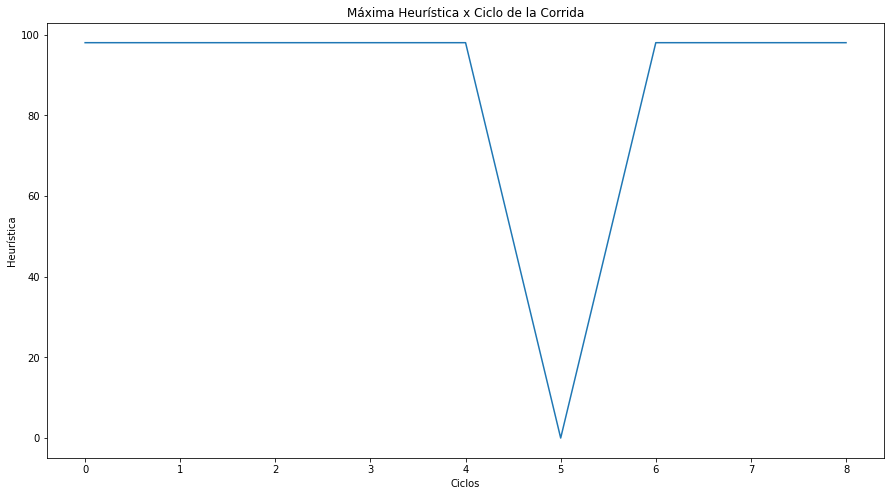

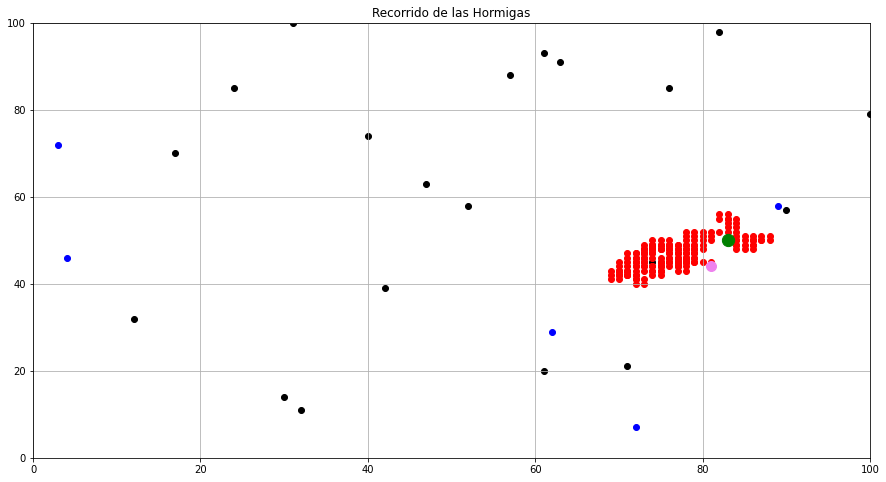

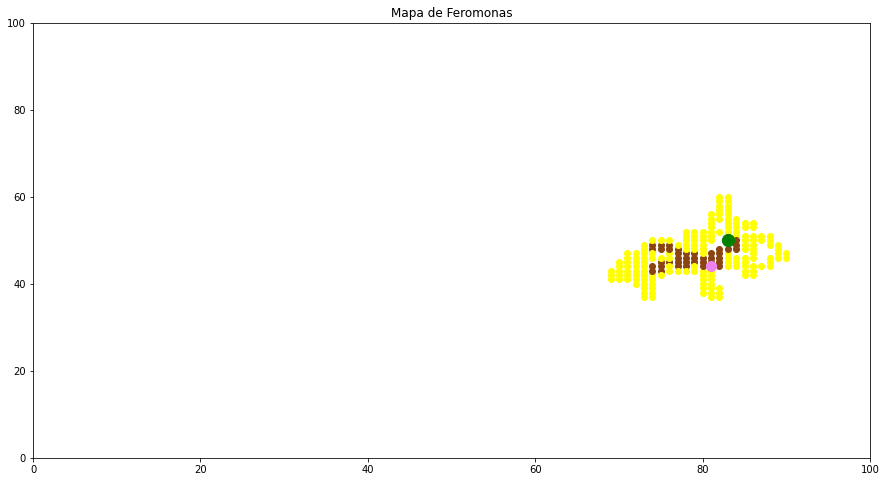

In [7]:
## MOSTRAR GRAFICO DE LA CORRIDA
plt.figure(figsize=(15,8)) 
plt.plot(ciclosMaxAptitud)
plt.title('Máxima Heurística x Ciclo de la Corrida')
plt.xlabel('Ciclos')
plt.ylabel('Heurística')
plt.show()

## MOSTRAR GRAFICO DEL MOVIMIENTO DE LAS HORMIGAS
plt.figure(figsize=(15,8)) 

## --en Negro: posiciones de los obstáculos a esquivar
for posi in mapa.posObstaculos:
  plt.scatter(posi[0], posi[1], color='black')

## --en Rojo: posiciones de las Hormigas de cada ciclo
for rpos in mejorRecCorrida.recorridoUltimo:
  plt.scatter(rpos[0], rpos[1], color='red')

## -- en Azul: Máximos Locales (positivos)
## -- en Cyan: Mínimos Locales (negativos)
## -- en Verde: Máximo Óptimo
for posi, vali in zip(mapa.posMaximos, mapa.valMaximos):    
  if vali < 0:
      plt.scatter(posi[0], posi[1], color='cyan')
  else:
      plt.scatter(posi[0], posi[1], color='blue')
plt.scatter(mapa.posMaximoGlobal[0], mapa.posMaximoGlobal[1], color='green', s=150)

## --en Violeta: Posicicón del Homiguero
plt.scatter(mapa.posHormiguero[0], mapa.posHormiguero[1], color='violet', s=100)

plt.title('Recorrido de las Hormigas')
plt.xlim(MIN_ESPACIO_BUSQ, MAX_ESPACIO_BUSQ)
plt.ylim(MIN_ESPACIO_BUSQ, MAX_ESPACIO_BUSQ)
plt.grid(True)
plt.show()

## MOSTRAR GRAFICO DEL MAPA DE FEROMONAS
mapa.mostrarMapaFeromonas()